In [1]:
import pandas as pd
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import time
import re
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import requests
import os
from difflib import SequenceMatcher

In [ ]:
DATA_PATH = './data/'
WEEL_INFO = 'wear_data_train.csv'
SERVICE_INFO = 'service_dates.csv'
start_date = '2023-01-01'
end_date = '2025-09-30'
target = 'wear_intensity'

In [3]:
df_weels = pd.read_csv(DATA_PATH + WEEL_INFO)
print(df_weels.head())

   wheel_id locomotive_series  locomotive_number                   depo  \
0    757277           2ТЭ10МК               3622           ТЧЭ-11 ТЫНДА   
1     66424             ТЭП70              19662  ТЧЭ-14 СПБ ВАРШАВСКИЙ   
2     96621             ТЭМ7А              25190     ТЧЭ-12 КРАСНОДАР-1   
3      2969            2ТЭ10М                990           ТЧЭ-11 ТЫНДА   
4    237052             ВЛ80С               2114        ТЧЭ-9 ЛЯНГАСОВО   

   steel_num  mileage_start  wear_intensity  
0   437329.0      4255610.0        0.602567  
1   313343.0      2404282.0        0.662944  
2   911777.0       365744.0        1.233710  
3    39434.0      4212712.0        0.739783  
4   310115.0      4899536.0        0.635913  


In [4]:
def normalize_text(text):
    if pd.isna(text) or not isinstance(text, str):
        return ""
    text = text.lower().strip()
    text = re.sub(r'[-\s]+', ' ', text)
    text = re.sub(r'\b(тчэ|эксплуатационное|локомотивное|депо|участок|тч)\b', '', text)
    return text.strip()

def extract_tche_code(text):
    if not isinstance(text, str):
        return None
    match = re.search(r'ТЧЭ[-\s]*(\d+)', text, re.IGNORECASE)
    if match:
        return f"ТЧЭ-{match.group(1)}"
    match = re.search(r'\b(\d{1,2})\b', text)
    if match:
        return f"ТЧЭ-{match.group(1)}"
    return None

if not os.path.exists(DATA_PATH + 'depo_mapping.csv'):
    depos_name = list(df_weels['depo'].unique())
    
    with open('дирекции_тяги.txt', 'r', encoding='utf-8') as file:
        text = file.read()

    traction_directorates_info = text.split('\n\n')
    depo_mapping = []
    
    for original_depo in depos_name:
        if pd.isna(original_depo) or original_depo == '':
            continue
            
        original_depo = str(original_depo).strip()
        original_normalized = normalize_text(original_depo)
        original_tche = extract_tche_code(original_depo)
        
        best_match = None
        best_score = 0
        
        for info_block in traction_directorates_info:
            info = info_block.strip().split('\n')
            if len(info) < 4:
                continue
                
            directorate = info[0].strip()
            address = info[2].strip()
            
            for line in info[3:]:
                line = line.strip()
                if not line:
                    continue
                
                tche_match = re.search(r'ТЧЭ-(\d+)', line)
                if not tche_match:
                    continue
                    
                tche_code = tche_match.group(0)
                depot_full_name = line.strip()
                cleaned_depot = re.sub(r'^\d+\.\s*', '', depot_full_name)
                normalized_depot = cleaned_depot.replace('Эксплуатационное локомотивное депо ', '').rstrip('();')
                
                score = 0
                if original_tche and tche_code == original_tche:
                    score = 1.0
                elif original_tche and tche_code.split('-')[1] == original_tche.split('-')[1]:
                    score = 0.8
                elif original_tche and original_tche in line:
                    score = 0.7
                elif normalized_depot.lower() in original_depo.lower() or original_depo.lower() in normalized_depot.lower():
                    score = 0.6
                else:
                    from difflib import SequenceMatcher
                    score = SequenceMatcher(None, original_normalized, normalize_text(normalized_depot)).ratio()
                
                if score > best_score:
                    best_score = score
                    best_match = {
                        'depo': original_depo,
                        'directorate': directorate,
                        'address': address,
                        'full_name': cleaned_depot,
                        'tche_code': tche_code
                    }
        
        if best_match and best_score > 0.5:
            depo_mapping.append(best_match)

    df_depos = pd.DataFrame(depo_mapping)
    df_depos.to_csv(DATA_PATH + 'depo_mapping.csv', index=False, encoding='utf-8')
else:
    df_depos = pd.read_csv(DATA_PATH + 'depo_mapping.csv', encoding='utf-8')

In [5]:
display(df_depos)

,depo,directorate,address,full_name,tche_code
0,ТЧЭ-11 ТЫНДА,Северная дирекция тяги,"Россия, 150003, г. Ярославль, ул. Республиканс...",Эксплуатационное локомотивное депо Лоста (ТЧЭ-...,ТЧЭ-11
1,ТЧЭ-14 СПБ ВАРШАВСКИЙ,Октябрьская дирекция тяги,"Россия, 191036, г. Санкт-Петербург, Невский пр...",Эксплуатационное локомотивное депо Санкт-Петер...,ТЧЭ-14
2,ТЧЭ-12 КРАСНОДАР-1,Октябрьская дирекция тяги,"Россия, 191036, г. Санкт-Петербург, Невский пр...",Эксплуатационное локомотивное депо Санкт-Петер...,ТЧЭ-12
3,ТЧЭ-9 ЛЯНГАСОВО,Горьковская дирекция тяги,"Россия, 603058, г. Нижний Новгород, ул. Октябр...",Эксплуатационное локомотивное депо Лянгасово (...,ТЧЭ-9
4,ТЧЭ-4 ЛИСКИ-УЗЛОВАЯ,Октябрьская дирекция тяги,"Россия, 191036, г. Санкт-Петербург, Невский пр...",Эксплуатационное локомотивное депо Бологовское...,ТЧЭ-4
...,...,...,...,...,...
112,ТЧЭ-1 ЗЛАТОУСТ,Октябрьская дирекция тяги,"Россия, 191036, г. Санкт-Петербург, Невский пр...",Эксплуатационное локомотивное депо Московское ...,ТЧЭ-1
113,ТЧЭ-2 ОМСК,Московская дирекция тяги,"Россия, 107996, г. Москва, ул. Краснопрудная, 20",Эксплуатационное локомотивное депо Лихоборы-Ок...,ТЧЭ-2
114,ТЧЭ-12 КОЧЕТОВКА,Октябрьская дирекция тяги,"Россия, 191036, г. Санкт-Петербург, Невский пр...",Эксплуатационное локомотивное депо Санкт-Петер...,ТЧЭ-12
115,ТЧЭ-10 ЧУСОВСКОЕ,Куйбышевская дирекция тяги,"Россия, 443030, Самарская область, г. Самара, ...",Эксплуатационное локомотивное депо Самара (ТЧЭ...,ТЧЭ-10


In [6]:
df_weels = df_weels.merge(df_depos[['depo', 'directorate']], on='depo', how='left')
display(df_weels)

,wheel_id,locomotive_series,locomotive_number,depo,steel_num,mileage_start,wear_intensity,directorate
0,757277,2ТЭ10МК,3622,ТЧЭ-11 ТЫНДА,437329.0,4255610.0,0.602567,Северная дирекция тяги
1,66424,ТЭП70,19662,ТЧЭ-14 СПБ ВАРШАВСКИЙ,313343.0,2404282.0,0.662944,Октябрьская дирекция тяги
2,96621,ТЭМ7А,25190,ТЧЭ-12 КРАСНОДАР-1,911777.0,365744.0,1.233710,Октябрьская дирекция тяги
3,2969,2ТЭ10М,990,ТЧЭ-11 ТЫНДА,39434.0,4212712.0,0.739783,Северная дирекция тяги
4,237052,ВЛ80С,2114,ТЧЭ-9 ЛЯНГАСОВО,310115.0,4899536.0,0.635913,Горьковская дирекция тяги
...,...,...,...,...,...,...,...,...
407664,208710,ВЛ80С,13810,ТЧЭ-6 БАТАЙСК,920079.0,4226892.0,0.649830,Московская дирекция тяги
407665,3106,3ТЭ10МК,3860,ТЧЭ-11 ТЫНДА,133476.0,3842051.0,0.435673,Северная дирекция тяги
407666,50050,2ТЭ25КМ,8920,ТЧЭ-46 БРЯНСК-2,215879.0,661385.0,0.701438,Московская дирекция тяги
407667,425234,3ЭС5К,8448,ТЧЭ-3 ИЛАНСКАЯ,133799.0,920661.0,0.251745,Московская дирекция тяги


In [7]:
df_weels[df_weels['directorate'].isna()]['depo'].unique()

<StringArray>
['ТЧЭ-36 УЗЛОВАЯ ИМ. ЗОЛОТАРЕВА К.Я.']
Length: 1, dtype: str

In [8]:
# if not os.path.exists(DATA_PATH + 'depos_with_coords.csv'):
#     geolocator = Nominatim(user_agent="russian_railway_depots")
#     geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1.2)

#     BAD_KEYWORDS = ['пожарное', 'авто', 'трамвайное', 'троллейбусное', 'гараж', 'автобус']

#     def get_osm_coords(query, required_substring):
#         try:
#             loc = geocode(query, timeout=10, country_codes='ru')
#             if not loc or not loc.latitude:
#                 return None, None, None

#             addr = loc.address.lower()
#             if any(bad in addr for bad in BAD_KEYWORDS):
#                 return None, None, None
#             if required_substring.lower() not in addr:
#                 return None, None, None

#             return loc.latitude, loc.longitude, loc.address
#         except Exception:
#             return None, None, None

#     def extract_station_and_tche(full_name):
#         tche_match = re.search(r'ТЧЭ-\d+', full_name)
#         tche = tche_match.group(0) if tche_match else None

#         station_match = re.search(r'депо\s+([^(]+?)\s*\(', full_name)
#         if not station_match:
#             station_match = re.search(r'депо\s+(.+)', full_name)
#         station = station_match.group(1).strip() if station_match else None

#         if station:
#             station = re.sub(r'[;()"]', '', station).strip()
#         return tche, station

#     print("\nПоиск координат...")
#     df_depos['lat'] = None
#     df_depos['lon'] = None
#     df_depos['osm_address'] = None

#     for i, (idx, row) in enumerate(df_depos.iterrows(), start=1):
#         print(f"[{i}/{len(df_depos)}] {row['full_name']}")

#         tche, station = extract_station_and_tche(row['full_name'])
#         found = False

#         if tche and station:
#             query = f"{tche} {station}"
#             lat, lon, addr = get_osm_coords(query, tche)
#             if lat:
#                 print(f"Найдено: {query}")
#                 print(f"Адрес: {addr[:150]}...")
#                 df_depos.at[idx, 'lat'] = lat
#                 df_depos.at[idx, 'lon'] = lon
#                 df_depos.at[idx, 'osm_address'] = addr
#                 found = True

#         if not found and station:
#             for prefix in ['', 'локомотивное ', 'железнодорожное ']:
#                 query = f"{prefix}депо {station}"
#                 lat, lon, addr = get_osm_coords(query, station)
#                 if lat:
#                     print(f"Найдено: {query}")
#                     print(f"Адрес: {addr[:150]}...")
#                     df_depos.at[idx, 'lat'] = lat
#                     df_depos.at[idx, 'lon'] = lon
#                     df_depos.at[idx, 'osm_address'] = addr
#                     found = True
#                     break

#         if not found:
#             print("Не найдено")

#         time.sleep(1.2)

#     print("\nРучной ввод координат")
#     missing_depots = df_depos[df_depos['lat'].isna()].copy()
#     print(f"Ненайденных депо: {len(missing_depots)}")

#     if len(missing_depots) > 0:
#         for i, (idx, row) in enumerate(missing_depots.iterrows(), start=1):
#             print(f"[{i}/{len(missing_depots)}] {row['full_name']}")
#             print(f"Адрес: {row.get('address', 'Не указан')}")
            
#             while True:
#                 coords_input = input("Введите координаты (lat,lon) или 'skip': ").strip()
                
#                 if coords_input.lower() == 'skip':
#                     break
                    
#                 try:
#                     lat_str, lon_str = coords_input.split(',')
#                     lat = float(lat_str.strip())
#                     lon = float(lon_str.strip())
                    
#                     if 41 <= lat <= 82 and 19 <= lon <= 180:
#                         df_depos.at[idx, 'lat'] = lat
#                         df_depos.at[idx, 'lon'] = lon
#                         df_depos.at[idx, 'osm_address'] = f"Ручной ввод: {row['full_name']}"
#                         print(f"Сохранено: {lat:.6f}, {lon:.6f}")
#                         break
#                     else:
#                         print("Координаты вне пределов России")
                        
#                 except ValueError:
#                     print("Неверный формат. Используйте: 55.7558,37.6176 или 'skip'")

#     result_df = df_depos.dropna(subset=['lat'])[
#         ['directorate', 'full_name', 'address', 'lat', 'lon', 'osm_address']
#     ]
#     print("\nФИНАЛЬНЫЕ РЕЗУЛЬТАТЫ")
#     print(result_df.to_string(index=False))
#     print(f"\nНайдено: {len(result_df)} из {len(df_depos)}")

#     result_df.to_csv(DATA_PATH + 'depos_with_coords.csv', index_label='original_depo_name', encoding='utf-8')
# else:
#     result_df = pd.read_csv(DATA_PATH+'depos_with_coords.csv', encoding='utf-8', index_col='original_depo_name')

In [9]:
# import requests
# import pandas as pd
# import time
# from datetime import datetime
# import numpy as np
# from functools import lru_cache
# import os

# # Конфигурация
# YANDEX_API_KEY = "8724f20e-3300-4f91-97dd-9d4ca43fb386"  # Лучше в os.getenv()
# OPENWEATHER_API_KEY = "5e457ee9726aa3f5a09a6176c21077cd"  # Лучше в os.getenv()

# # Параметры для оценки износа оборудования
# EQUIPMENT_STRESS_FACTORS = {
#     'temperature_amplitude': {'weight': 0.3, 'description': 'Перепады температур'},
#     'precipitation': {'weight': 0.2, 'description': 'Осадки (коррозия)'},
#     'wind_speed': {'weight': 0.15, 'description': 'Ветровая нагрузка'},
#     'snow_ice_days': {'weight': 0.15, 'description': 'Снег/лед (обледенение)'},
#     'humidity': {'weight': 0.1, 'description': 'Влажность (коррозия)'},
#     'corrosive_environment': {'weight': 0.1, 'description': 'Агрессивная среда'}
# }

# def get_climate_risk_score(climate_data):
#     """Рассчитывает общий риск износа оборудования от 0 до 100"""
#     score = 0
    
#     # Амплитуда температур (больше 40°C - высокий риск)
#     if climate_data.get('temp_amplitude'):
#         amp = climate_data['temp_amplitude']
#         score += min(30, amp * 0.75) * EQUIPMENT_STRESS_FACTORS['temperature_amplitude']['weight']
    
#     # Осадки (более 800мм/год - высокий риск коррозии)
#     if climate_data.get('annual_precipitation'):
#         precip = climate_data['annual_precipitation']
#         score += min(25, precip / 40) * EQUIPMENT_STRESS_FACTORS['precipitation']['weight']
    
#     # Ветер (более 10 м/с - высокий риск)
#     if climate_data.get('avg_wind_speed'):
#         wind = climate_data['avg_wind_speed']
#         score += min(20, wind * 2) * EQUIPMENT_STRESS_FACTORS['wind_speed']['weight']
    
#     # Дни со снегом (более 100 дней - высокий риск)
#     if climate_data.get('snow_days'):
#         snow = climate_data['snow_days']
#         score += min(20, snow / 5) * EQUIPMENT_STRESS_FACTORS['snow_ice_days']['weight']
    
#     # Влажность (более 70% - высокий риск)
#     if climate_data.get('avg_humidity'):
#         humidity = climate_data['avg_humidity']
#         score += min(15, humidity * 0.15) * EQUIPMENT_STRESS_FACTORS['humidity']['weight']
    
#     # Агрессивная среда (морской/химический/промышленный)
#     env_risk = {
#         'marine': 25,  # Морской воздух
#         'coastal': 20,
#         'industrial': 20,
#         'urban': 10,
#         'agricultural': 5,
#         'forest': 0,
#         'tundra': 5
#     }
    
#     land_cover = climate_data.get('land_cover', '').lower()
#     for env, risk in env_risk.items():
#         if env in land_cover:
#             score += risk * EQUIPMENT_STRESS_FACTORS['corrosive_environment']['weight']
#             break
    
#     return round(min(100, score), 1)

# def get_openweather_industrial_climate(lat, lon):
#     """
#     OpenWeatherMap - приоритетный источник.
#     Специализирован для оценки износа оборудования.
#     """
#     try:
#         # One Call API 3.0
#         url = "https://api.openweathermap.org/data/3.0/onecall"
#         params = {
#             "lat": lat,
#             "lon": lon,
#             "exclude": "minutely,alerts",
#             "units": "metric",
#             "appid": OPENWEATHER_API_KEY
#         }
        
#         response = requests.get(url, params=params, timeout=15)
#         if response.status_code != 200:
#             return None
            
#         data = response.json()
        
#         # Текущие условия
#         current = data.get('current', {})
        
#         # Прогноз на 7 дней (для пиковых нагрузок)
#         daily_7 = data.get('daily', [])[:7]
        
#         # Исторические данные за 30 дней (для расчета нормалей)
#         daily_30 = data.get('daily', [])[:30]
        
#         if not daily_30:
#             return None
        
#         # --- КРИТИЧЕСКИЕ ПАРАМЕТРЫ ДЛЯ ИЗНОСА ---
        
#         # 1. Температурные экстремумы и перепады
#         temps_max = []
#         temps_min = []
#         for day in daily_30:
#             temp = day.get('temp', {})
#             if isinstance(temp, dict):
#                 temps_max.append(temp.get('max'))
#                 temps_min.append(temp.get('min'))
#             else:
#                 temps_max.append(temp)
#                 temps_min.append(temp)
        
#         temps_max = [t for t in temps_max if t is not None]
#         temps_min = [t for t in temps_min if t is not None]
        
#         record_temp_max = max(temps_max) if temps_max else None
#         record_temp_min = min(temps_min) if temps_min else None
#         temp_amplitude = (record_temp_max - record_temp_min) if record_temp_max and record_temp_min else None
        
#         # 2. Осадки (коррозионный износ)
#         total_precip = sum([day.get('rain', 0) for day in daily_30])
#         # Экстраполяция на год
#         annual_precipitation = total_precip * 12 if total_precip else None
        
#         # 3. Ветровая нагрузка
#         wind_speeds = [day.get('wind_speed', 0) for day in daily_30]
#         max_wind = max(wind_speeds) if wind_speeds else None
#         avg_wind_speed = round(sum(wind_speeds) / len(wind_speeds), 1) if wind_speeds else None
        
#         # 4. Снег и лед
#         snow_days_30 = sum([1 for day in daily_30 if day.get('snow', 0) > 0])
#         snow_days_year = snow_days_30 * 12 if snow_days_30 else 0
        
#         # 5. Влажность (коррозия)
#         humidity_values = [day.get('humidity', 0) for day in daily_30 if day.get('humidity')]
#         avg_humidity = round(sum(humidity_values) / len(humidity_values), 1) if humidity_values else None
        
#         # 6. Давление (влияет на герметичность)
#         pressure_values = [day.get('pressure', 0) for day in daily_30 if day.get('pressure')]
#         avg_pressure = round(sum(pressure_values) / len(pressure_values), 1) if pressure_values else None
        
#         # 7. Грозы и экстремальные явления
#         storm_days = sum([1 for day in daily_7 if day.get('weather', [{}])[0].get('id', 0) in [200, 201, 202, 230, 231, 232, 210, 211, 212, 221]])
        
#         # 8. УФ-индекс (старение изоляции)
#         uvi_values = [day.get('uvi', 0) for day in daily_7 if day.get('uvi')]
#         max_uvi = max(uvi_values) if uvi_values else None
        
#         # 9. Сезонные температуры (для оценки термоциклирования)
#         monthly_temps = {}
#         for day in daily_30:
#             dt = datetime.fromtimestamp(day['dt'])
#             month = dt.month
#             temp_day = day.get('temp', {}).get('day') if isinstance(day.get('temp'), dict) else day.get('temp')
            
#             if month not in monthly_temps:
#                 monthly_temps[month] = []
#             if temp_day:
#                 monthly_temps[month].append(temp_day)
        
#         # Лето (6-8)
#         summer_temps = []
#         for m in [6,7,8]:
#             if m in monthly_temps:
#                 summer_temps.extend(monthly_temps[m])
#         avg_temp_summer = round(sum(summer_temps) / len(summer_temps), 1) if summer_temps else None
        
#         # Зима (12,1,2)
#         winter_temps = []
#         for m in [12,1,2]:
#             if m in monthly_temps:
#                 winter_temps.extend(monthly_temps[m])
#         avg_temp_winter = round(sum(winter_temps) / len(winter_temps), 1) if winter_temps else None
        
#         return {
#             # Температурные параметры
#             'avg_temp_summer': avg_temp_summer,
#             'avg_temp_winter': avg_temp_winter,
#             'record_temp_max': record_temp_max,
#             'record_temp_min': record_temp_min,
#             'temp_amplitude': temp_amplitude,
            
#             # Осадки и влажность
#             'annual_precipitation': round(annual_precipitation, 1) if annual_precipitation else None,
#             'avg_humidity': avg_humidity,
#             'snow_days': snow_days_year,
#             'max_precip_day': max([day.get('rain', 0) for day in daily_30]) if daily_30 else None,
            
#             # Ветер
#             'avg_wind_speed': avg_wind_speed,
#             'max_wind': max_wind,
            
#             # Экстремальные условия
#             'storm_days_year': storm_days * 52,  # Экстраполяция на год
#             'max_uvi': max_uvi,
#             'avg_pressure': avg_pressure,
            
#             # Источник
#             'climate_source': 'OpenWeatherMap 3.0'
#         }
        
#     except Exception as e:
#         print(f"  OpenWeather ошибка: {e}")
#         return None

# def get_yandex_climate(lat, lon):
#     """
#     Яндекс.Погода - резервный источник
#     """
#     try:
#         url = "https://api.weather.yandex.ru/v2/forecast"
#         headers = {"X-Yandex-API-Key": YANDEX_API_KEY}
#         params = {
#             "lat": lat,
#             "lon": lon,
#             "lang": "ru_RU",
#             "limit": 7
#         }
        
#         response = requests.get(url, headers=headers, params=params, timeout=10)
#         if response.status_code != 200:
#             return None
            
#         data = response.json()
        
#         # Климатические нормы
#         norm = data.get('info', {}).get('climate', {})
        
#         # Текущие условия
#         fact = data.get('fact', {})
        
#         # Прогноз для экстраполяции
#         forecasts = data.get('forecasts', [])
        
#         # Рассчитываем дополнительные параметры
#         snow_days = norm.get('snow_days')
#         if snow_days:
#             snow_days = snow_days * 30  # Аппроксимация
        
#         return {
#             'avg_temp_summer': norm.get('temp_summer_avg'),
#             'avg_temp_winter': norm.get('temp_winter_avg'),
#             'record_temp_max': norm.get('temp_max_abs'),
#             'record_temp_min': norm.get('temp_min_abs'),
#             'temp_amplitude': norm.get('temp_max_abs') - norm.get('temp_min_abs') if norm.get('temp_max_abs') and norm.get('temp_min_abs') else None,
#             'annual_precipitation': norm.get('precip_sum'),
#             'avg_wind_speed': norm.get('wind_speed_avg'),
#             'snow_days': snow_days,
#             'avg_humidity': fact.get('humidity'),
#             'avg_pressure': fact.get('pressure_mm'),
#             'climate_source': 'Yandex.Weather'
#         }
        
#     except Exception as e:
#         print(f"  Яндекс API ошибка: {e}")
#         return None

# def get_land_cover_and_elevation(lat, lon):
#     """
#     Определяет рельеф, тип местности и агрессивность среды
#     """
#     result = {
#         'land_cover': 'Unknown',
#         'elevation': None,
#         'terrain_type': 'Unknown',
#         'corrosive_environment': 'None',
#         'coastal_proximity': False
#     }
    
#     try:
#         # 1. Open-Elevation (бесплатный)
#         elev_url = f"https://api.open-elevation.com/api/v1/lookup"
#         elev_params = {"locations": f"{lat},{lon}"}
        
#         elev_response = requests.get(elev_url, params=elev_params, timeout=10)
#         if elev_response.status_code == 200:
#             elev_data = elev_response.json()
#             result['elevation'] = elev_data['results'][0]['elevation']
            
#             # Классификация высоты
#             if result['elevation'] < 200:
#                 result['terrain_type'] = 'Lowland'
#             elif result['elevation'] < 500:
#                 result['terrain_type'] = 'Hills'
#             elif result['elevation'] < 1500:
#                 result['terrain_type'] = 'Mountains'
#             else:
#                 result['terrain_type'] = 'High mountains'
        
#     except:
#         pass
    
#     try:
#         # 2. OpenStreetMap для определения land cover
#         osm_url = "https://nominatim.openstreetmap.org/reverse"
#         osm_params = {
#             "lat": lat,
#             "lon": lon,
#             "format": "json",
#             "zoom": 14,
#             "addressdetails": 1,
#             "extratags": 1
#         }
        
#         response = requests.get(osm_url, params=osm_params, timeout=10, 
#                               headers={'User-Agent': 'IndustrialClimateResearch/1.0'})
        
#         if response.status_code == 200:
#             data = response.json()
            
#             # Определяем тип местности
#             address = data.get('address', {})
#             extratags = data.get('extratags', {})
            
#             land_types = []
            
#             # Проверяем различные теги
#             if 'natural' in address:
#                 land_types.append(address['natural'])
#             if 'landuse' in address:
#                 land_types.append(address['landuse'])
#             if 'wetland' in address:
#                 land_types.append('wetland')
#             if 'water' in address:
#                 land_types.append('water')
#             if 'sea' in address or 'ocean' in str(address).lower():
#                 result['coastal_proximity'] = True
#                 land_types.append('coastal')
            
#             # Проверяем промышленные зоны
#             if 'industrial' in address or 'industrial' in str(extratags):
#                 land_types.append('industrial')
#                 result['corrosive_environment'] = 'Industrial'
            
#             # Проверяем близость к морю
#             if any(x in address for x in ['sea', 'ocean', 'coast']):
#                 result['coastal_proximity'] = True
#                 result['corrosive_environment'] = 'Marine'
            
#             # Проверяем тип растительности
#             if 'forest' in address or 'wood' in address:
#                 land_types.append('forest')
#             elif 'grass' in address or 'meadow' in address:
#                 land_types.append('grassland')
#             elif 'farm' in address:
#                 land_types.append('agricultural')
            
#             result['land_cover'] = ', '.join(set(land_types)) if land_types else 'Urban'
            
#     except Exception as e:
#         print(f"  OSM ошибка: {e}")
        
#         # Fallback классификация по широте
#         if abs(lat) > 66.5:
#             result['land_cover'] = 'Arctic/Tundra'
#         elif abs(lat) > 50:
#             result['land_cover'] = 'Temperate forest'
#         elif abs(lat) > 30:
#             result['land_cover'] = 'Subtropical'
#         elif abs(lat) < 30:
#             result['land_cover'] = 'Tropical'
    
#     return result

# def collect_industrial_climate_data(result_df):
#     """
#     Основная функция сбора данных для оценки износа оборудования
#     """
#     print(f"Загружено записей с координатами: {len(result_df)}")
#     print("\nСБОР КЛИМАТИЧЕСКИХ И ГЕОГРАФИЧЕСКИХ ДАННЫХ")
#     print("=" * 60)
    
#     climate_data = []
#     total = len(result_df)
    
#     for i, (idx, row) in enumerate(result_df.iterrows(), 1):
#         print(f"[{i}/{total}] {row['full_name'][:50]}...")
        
#         lat = row['lat']
#         lon = row['lon']
        
#         record = {
#             'full_name': row['full_name'],
#             'directorate': row.get('directorate', 'Unknown'),
#             'address': row.get('address', 'Unknown'),
#             'lat': lat,
#             'lon': lon
#         }
        
#         # 1. Приоритет: OpenWeatherMap
#         print("    Получение климата...")
#         climate = get_openweather_industrial_climate(lat, lon)
        
#         # 2. Резерв: Яндекс
#         if not climate:
#             print("    Резервный источник (Яндекс)...")
#             climate = get_yandex_climate(lat, lon)
        
#         # Добавляем климатические данные
#         if climate:
#             record.update(climate)
#         else:
#             print("    ! Нет данных о климате")
        
#         # 3. Данные о рельефе и местности
#         print("    Получение данных о местности...")
#         land_data = get_land_cover_and_elevation(lat, lon)
#         record.update(land_data)
        
#         # 4. Рассчитываем риск износа оборудования
#         if any(k in record for k in ['temp_amplitude', 'annual_precipitation', 'avg_wind_speed']):
#             record['equipment_risk_score'] = get_climate_risk_score(record)
#             # Категория риска
#             if record['equipment_risk_score'] >= 70:
#                 record['risk_category'] = 'HIGH'
#             elif record['equipment_risk_score'] >= 40:
#                 record['risk_category'] = 'MEDIUM'
#             else:
#                 record['risk_category'] = 'LOW'
        
#         climate_data.append(record)
#         time.sleep(0.5)  # Защита от rate limiting
    
#     return pd.DataFrame(climate_data)

# # Пример использования:
# climate_df = collect_industrial_climate_data(result_df)

# # Сохранение результатов:
# climate_df.to_csv('depots_industrial_climate.csv', index=False, encoding='utf-8')

# # Вывод ключевых показателей:
# display_cols = ['full_name', 'directorate', 'land_cover', 'terrain_type', 
#                 'avg_temp_winter', 'avg_temp_summer', 'temp_amplitude',
#                 'annual_precipitation', 'snow_days', 'avg_wind_speed', 
#                 'corrosive_environment', 'equipment_risk_score', 'risk_category']
# print(climate_df[display_cols].to_string())

In [10]:
df_service = pd.read_csv(DATA_PATH + SERVICE_INFO)

merge_column = 'locomotive_number'

drop_columns = []
for col in df_service.columns:
    if col != merge_column and col in df_weels.columns:
        drop_columns.append(col)
        print(col)

if drop_columns:
    df_service = df_service.drop(drop_columns, axis=1)

print(df_service.head())

df_service['service_type'] = np.where(
    df_service['service_type'] == 'обточка', 
    4, 
    df_service['service_type']
)
df_service['service_type'] = df_service['service_type'].astype(str)

# Преобразуем дату и сортируем
df_service['service_date'] = pd.to_datetime(df_service['service_date'])
df_service = df_service.sort_values(['locomotive_number', 'service_date']).reset_index(drop=True)

# Текущая дата
current_date = pd.Timestamp(end_date)

# ИСПРАВЛЕННАЯ функция для создания признаков
def create_service_features(group):
    dates = group['service_date'].values
    types = group['service_type'].values.astype(int)
    
    result = {
        'locomotive_number': group.name,
    }
    
    # Количество ремонтов каждого типа (1-4)
    for t in range(1, 5):
        count = sum(1 for typ in types if typ == t)
        result[f'total_service_type_{t}'] = count
    
    # Дни с последнего ремонта каждого типа
    last_dates = {}
    for date, typ in zip(dates, types):
        last_dates[typ] = max(last_dates.get(typ, date), date)
    
    for t in range(1, 5):
        last_date = last_dates.get(t, pd.Timestamp('1900-01-01'))
        days_since = (current_date - last_date).days
        result[f'days_since_last_type_{t}'] = days_since
    
    # Интервалы между ремонтами
    for t in range(1, 5):
        type_dates = sorted([d for d, typ in zip(dates, types) if typ == t])
        if len(type_dates) >= 2:
            intervals = [(type_dates[i+1] - type_dates[i]).astype('timedelta64[D]').astype(int) 
                        for i in range(len(type_dates)-1)]
            result[f'mean_days_between_type_{t}'] = np.mean(intervals)
            result[f'min_days_between_type_{t}'] = min(intervals)
            result[f'max_days_between_type_{t}'] = max(intervals)
        else:
            result[f'mean_days_between_type_{t}'] = np.nan
            result[f'min_days_between_type_{t}'] = np.nan
            result[f'max_days_between_type_{t}'] = np.nan
    
    # Дополнительные полезные признаки
    total_days = (current_date - dates.min()).days if len(dates) > 0 else 0
    result['total_service_count'] = len(dates)
    result['service_rate_per_month'] = len(dates) / max((total_days / 30.44), 1)
    result['age_days'] = total_days
    result['days_since_last_service'] = (current_date - dates.max()).days if len(dates) > 0 else np.nan
    
    # Тренд частоты ремонтов
    if len(dates) >= 3:
        days_from_now = [(current_date - d).days for d in dates]
        x = np.arange(len(days_from_now))
        slope = np.polyfit(x, days_from_now, 1)[0]
        result['service_frequency_trend'] = slope
    else:
        result['service_frequency_trend'] = 0
    
    return pd.Series(result)

# Применяем трансформацию
df_service = df_service.groupby('locomotive_number').apply(create_service_features).reset_index(drop=True)

print("Итоговая df_service:")
display(df_service.head())
print("\nКолонки в df_service:\n  ", '\n   '.join(df_service.columns.tolist()))


/tmp/ipykernel_53963/1663246693.py:1: DtypeWarning: Columns (0: service_type) have mixed types. Specify dtype option on import or set low_memory=False.
  df_service = pd.read_csv(DATA_PATH + SERVICE_INFO)


locomotive_series
   locomotive_number service_date service_type
0               3574   2023-08-26            1
1               6531   2024-07-04            1
2               6531   2024-11-09            1
3               6531   2025-04-21            1
4               6531   2025-01-19            1
Итоговая df_service:


,locomotive_number,total_service_type_1,total_service_type_2,total_service_type_3,total_service_type_4,days_since_last_type_1,days_since_last_type_2,days_since_last_type_3,days_since_last_type_4,mean_days_between_type_1,...,min_days_between_type_3,max_days_between_type_3,mean_days_between_type_4,min_days_between_type_4,max_days_between_type_4,total_service_count,service_rate_per_month,age_days,days_since_last_service,service_frequency_trend
0,1.0,7.0,2.0,2.0,5.0,145.0,669.0,669.0,476.0,140.500000,...,11.0,11.0,128.250000,4.0,209.0,16.0,0.492457,989.0,145.0,-44.277941
1,2.0,7.0,2.0,1.0,10.0,50.0,50.0,50.0,53.0,144.666667,...,NaN,NaN,105.333333,1.0,192.0,20.0,0.608192,1001.0,50.0,-53.584211
2,3.0,7.0,1.0,1.0,10.0,-37.0,133.0,133.0,134.0,156.666667,...,NaN,NaN,85.444444,3.0,171.0,19.0,0.640487,903.0,-37.0,-49.547368
3,4.0,7.0,1.0,1.0,10.0,-37.0,133.0,133.0,137.0,156.666667,...,NaN,NaN,85.222222,1.0,164.0,19.0,0.639779,904.0,-37.0,-50.807018
4,5.0,7.0,2.0,2.0,13.0,102.0,383.0,383.0,400.0,148.000000,...,13.0,13.0,49.333333,1.0,175.0,24.0,0.736452,992.0,102.0,-34.082174



Колонки в df_service:
   locomotive_number
   total_service_type_1
   total_service_type_2
   total_service_type_3
   total_service_type_4
   days_since_last_type_1
   days_since_last_type_2
   days_since_last_type_3
   days_since_last_type_4
   mean_days_between_type_1
   min_days_between_type_1
   max_days_between_type_1
   mean_days_between_type_2
   min_days_between_type_2
   max_days_between_type_2
   mean_days_between_type_3
   min_days_between_type_3
   max_days_between_type_3
   mean_days_between_type_4
   min_days_between_type_4
   max_days_between_type_4
   total_service_count
   service_rate_per_month
   age_days
   days_since_last_service
   service_frequency_trend


In [11]:
df = df_weels.merge(df_service, on='locomotive_number', how='outer')

# Заполняем пропуски для локомотивов без истории ремонтов
service_columns = [col for col in df_service.columns if col != 'locomotive_number']

for col in service_columns:
    if col in df.columns:
        if 'days_since' in col or 'age_days' in col or 'days_since_last_service' in col:
            # Для временных метрик: очень большое значение (никогда не ремонтировался)
            df[col] = df[col].fillna(99999)
        elif 'total_' in col or 'total_service_count' in col:
            # Для счетчиков: 0 ремонтов
            df[col] = df[col].fillna(0)
        elif 'service_rate_per_month' in col:
            # Для частоты: 0 ремонтов в месяц
            df[col] = df[col].fillna(0)
        elif 'service_frequency_trend' in col:
            # Для тренда: 0 (нет данных)
            df[col] = df[col].fillna(0)
        else:
            # Для всех остальных (mean/min/max интервалов): NaN
            df[col] = df[col].fillna(np.nan)

print("Итоговая объединенная таблица:")
display(df.head())
print(f"\nРазмер df: {df.shape}")
print(f"Локомотивов только в df_weels (без ремонтов): {(df_weels['locomotive_number'].isin(df_service['locomotive_number']) == False).sum()}")


Итоговая объединенная таблица:


,wheel_id,locomotive_series,locomotive_number,depo,steel_num,mileage_start,wear_intensity,directorate,total_service_type_1,total_service_type_2,...,min_days_between_type_3,max_days_between_type_3,mean_days_between_type_4,min_days_between_type_4,max_days_between_type_4,total_service_count,service_rate_per_month,age_days,days_since_last_service,service_frequency_trend
0,541447.0,2ЭС5К,1.0,ТЧЭ-9 ВИХОРЕВКА,926594.0,2627886.0,0.890218,Горьковская дирекция тяги,7.0,2.0,...,11.0,11.0,128.25,4.0,209.0,16.0,0.492457,989.0,145.0,-44.277941
1,221800.0,2ЭС5К,1.0,ТЧЭ-9 ВИХОРЕВКА,336288.0,2758308.0,0.421882,Горьковская дирекция тяги,7.0,2.0,...,11.0,11.0,128.25,4.0,209.0,16.0,0.492457,989.0,145.0,-44.277941
2,221799.0,2ЭС5К,1.0,ТЧЭ-9 ВИХОРЕВКА,336288.0,2762907.0,0.631242,Горьковская дирекция тяги,7.0,2.0,...,11.0,11.0,128.25,4.0,209.0,16.0,0.492457,989.0,145.0,-44.277941
3,221817.0,2ЭС5К,1.0,ТЧЭ-9 ВИХОРЕВКА,23194.0,2627886.0,0.491496,Горьковская дирекция тяги,7.0,2.0,...,11.0,11.0,128.25,4.0,209.0,16.0,0.492457,989.0,145.0,-44.277941
4,125656.0,2ЭС5К,1.0,ТЧЭ-9 ВИХОРЕВКА,422719.0,2841570.0,0.680876,Горьковская дирекция тяги,7.0,2.0,...,11.0,11.0,128.25,4.0,209.0,16.0,0.492457,989.0,145.0,-44.277941



Размер df: (420001, 33)
Локомотивов только в df_weels (без ремонтов): 118


In [12]:
wheels_amount = len(df['wheel_id'].unique())
print('Уникальных колёс:', wheels_amount, '\nВсего:', len(df))

Уникальных колёс: 354018 
Всего: 420001


In [13]:
df = df.drop('wheel_id', axis=1)
df_encoded = pd.get_dummies(df, prefix='color', dtype=int)

In [ ]:
df = df.dropna(subset=[target])

df['locomotive_number'] = df['locomotive_number'].astype(str)
categorical_features = (
    df.select_dtypes(include=['object', 'string']).columns.tolist()
)
numeric_cols = df.drop(columns=categorical_features).columns.tolist()
print('Категориальные признаки:\n  ', '\n   '.join(categorical_features))
print('\nЧисловые признаки:\n  ', '\n   '.join(numeric_cols))


Категориальные признаки:
   locomotive_series
   locomotive_number
   depo
   directorate

Числовые признаки:
   steel_num
   mileage_start
   wear_intensity
   total_service_type_1
   total_service_type_2
   total_service_type_3
   total_service_type_4
   days_since_last_type_1
   days_since_last_type_2
   days_since_last_type_3
   days_since_last_type_4
   mean_days_between_type_1
   min_days_between_type_1
   max_days_between_type_1
   mean_days_between_type_2
   min_days_between_type_2
   max_days_between_type_2
   mean_days_between_type_3
   min_days_between_type_3
   max_days_between_type_3
   mean_days_between_type_4
   min_days_between_type_4
   max_days_between_type_4
   total_service_count
   service_rate_per_month
   age_days
   days_since_last_service
   service_frequency_trend


In [15]:
print("Проверяем NaN в категориальных признаках:")
for col in categorical_features:
    if col in df.columns:
        nan_count = df[col].isna().sum()
        if nan_count > 0:
            print(f"{col}: {nan_count} NaN значений")
            # Заполняем категориальные NaN строкой "missing"
            df[col] = df[col].fillna("missing")

print("Все категориальные NaN заполнены!")
print("Проверяем:")
print(df[categorical_features].isna().sum())

Проверяем NaN в категориальных признаках:
directorate: 2938 NaN значений
Все категориальные NaN заполнены!
Проверяем:
locomotive_series    0
locomotive_number    0
depo                 0
directorate          0
dtype: int64


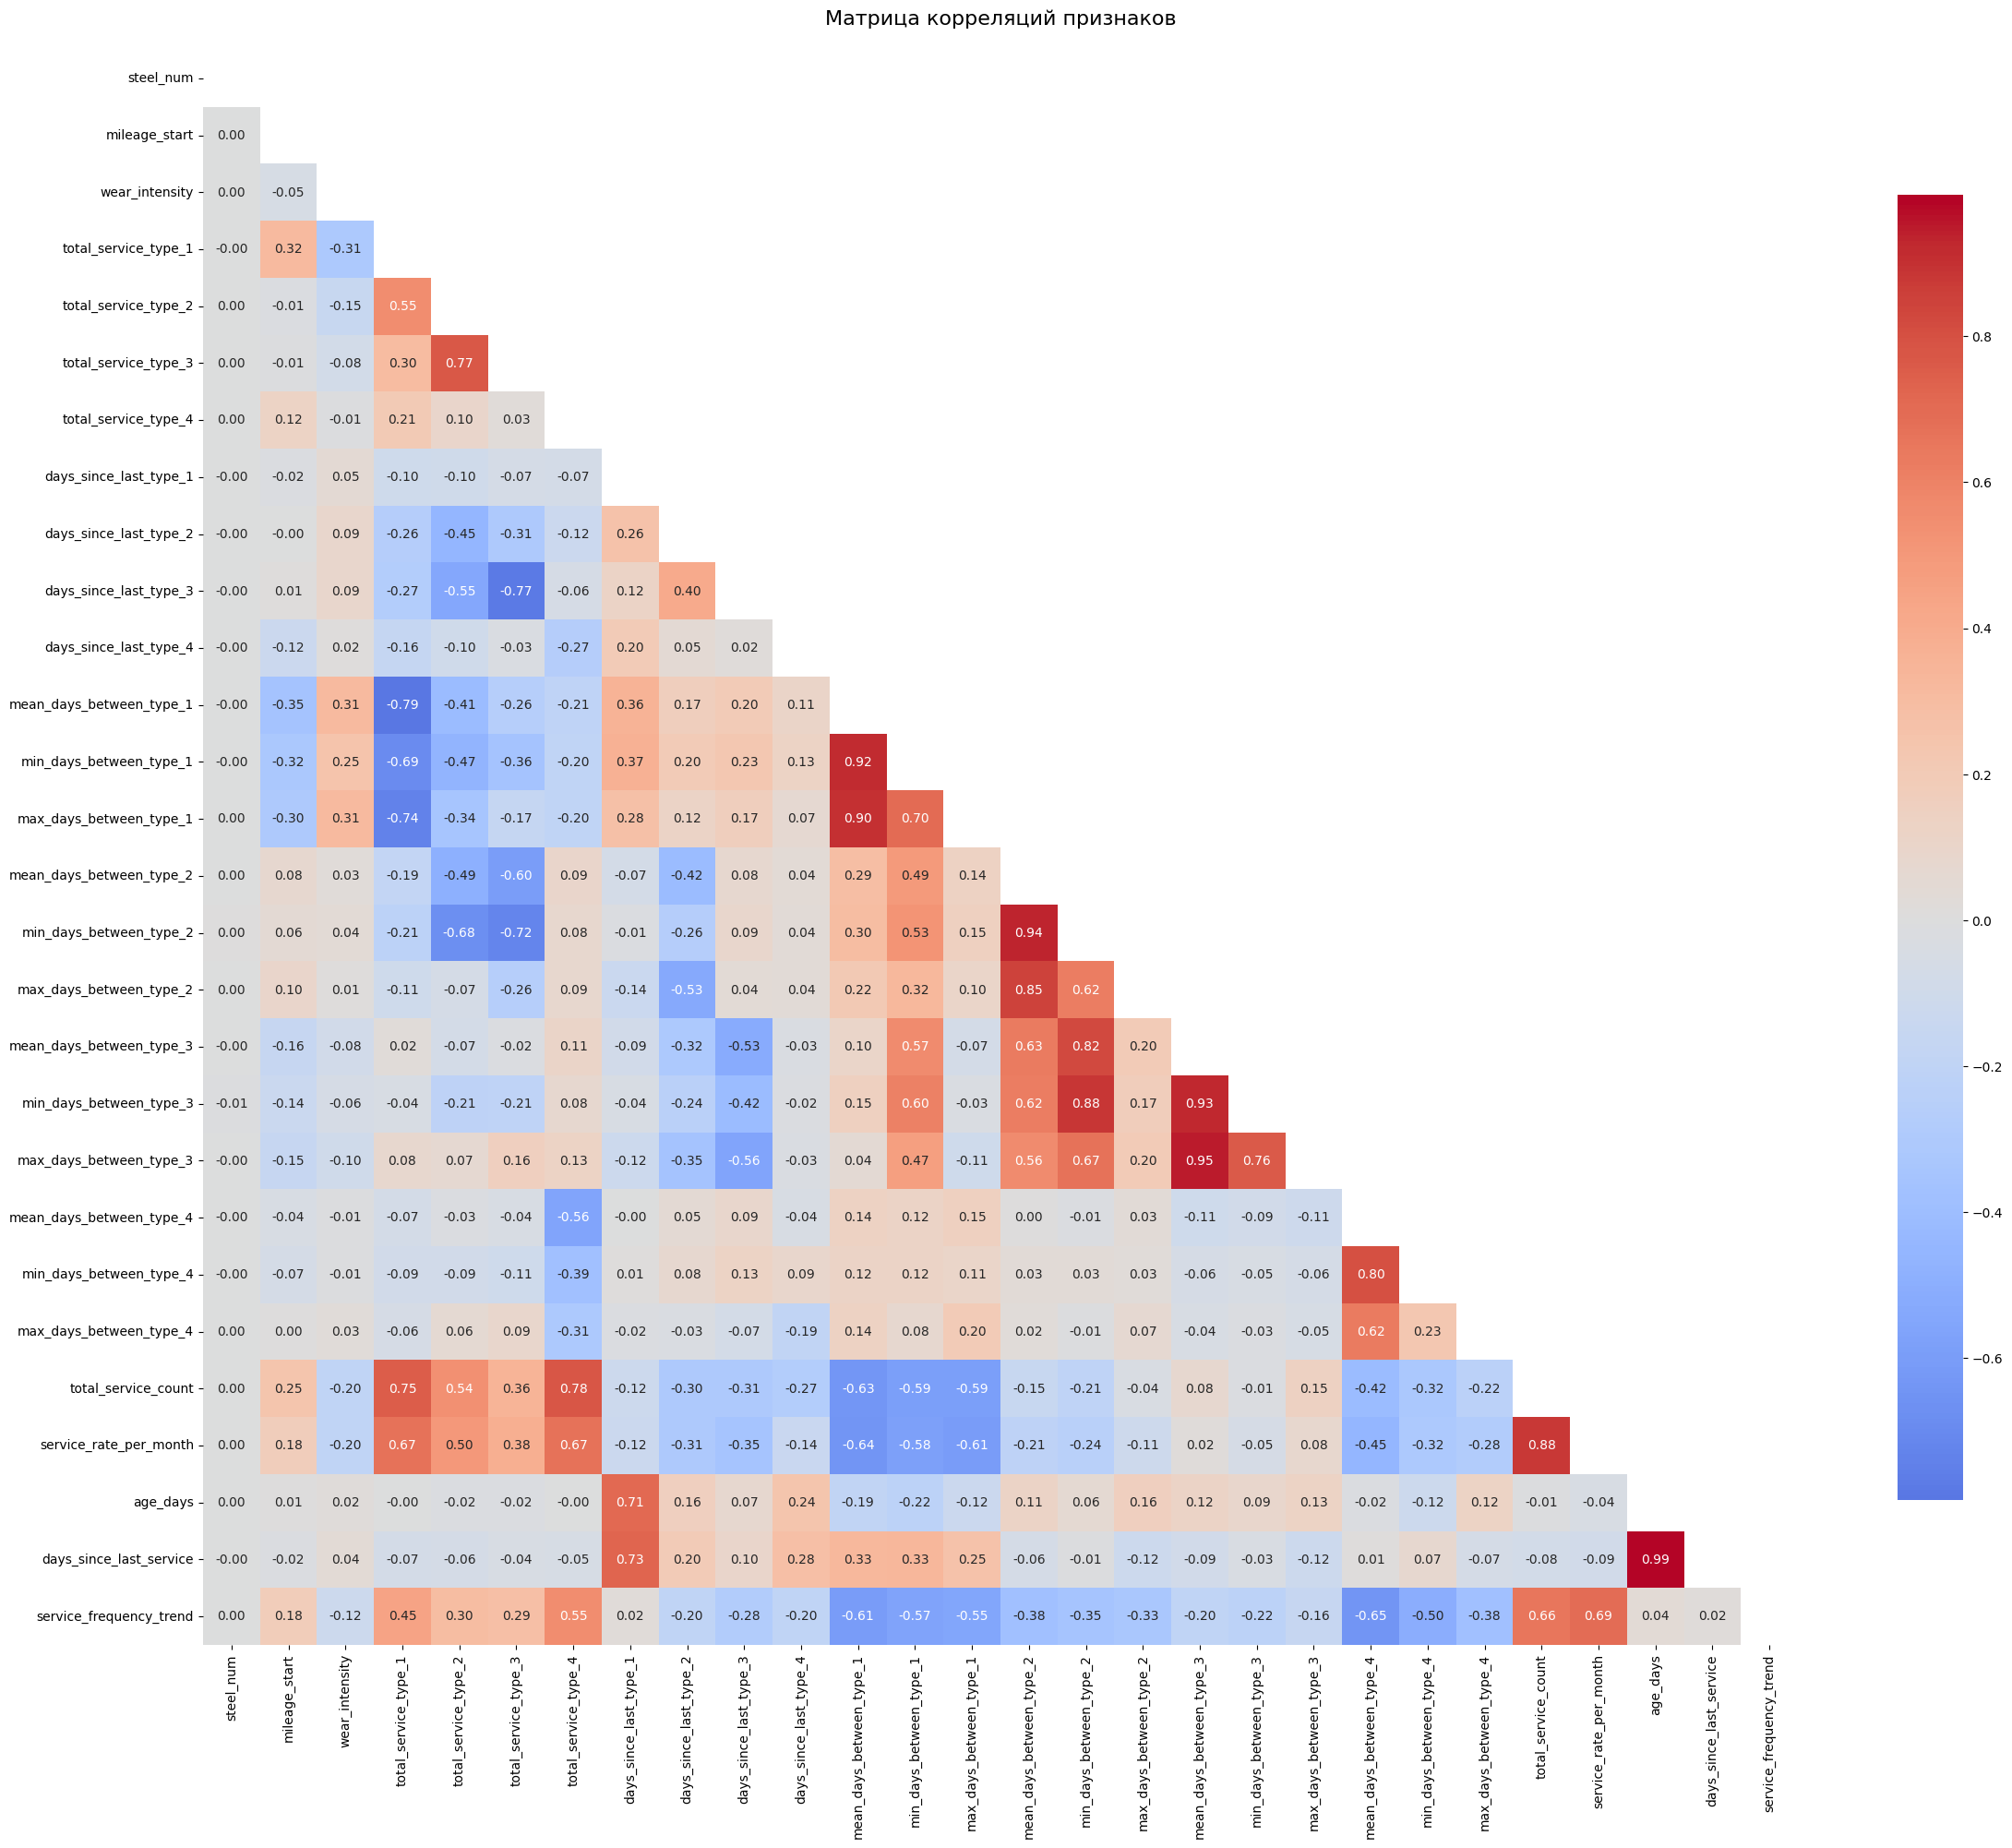

In [16]:
numeric_cols = df.drop(columns=categorical_features).columns.tolist()
corr_matrix = df[numeric_cols].corr()

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(24, 20))
sns.heatmap(
    corr_matrix, 
    mask=mask,
    annot=True,
    cmap='coolwarm',
    center=0,
    square=True,
    fmt='.2f',
    cbar_kws={"shrink": .8}
)

plt.title('Матрица корреляций признаков', fontsize=16, pad=20)
plt.tight_layout()
plt.show()


In [28]:
df.to_csv(DATA_PATH + 'dataset.csv', index=False)

In [ ]:
# y_train, y_test, X_train, X_test = train_test_split(
#     df[target], 
#     df.drop(target, axis=1), 
#     test_size=0.2,        # 20% на тест
#     random_state=42       # для воспроизводимости
# )

# print(f"Train: {X_train.shape}, Test: {X_test.shape}")
# print(f"y_train: {y_train.shape}, y_test: {y_test.shape}")

Train: (326135, 31), Test: (81534, 31)
y_train: (326135,), y_test: (81534,)


In [ ]:
# model = CatBoostRegressor(
#     iterations=1000,        # количество деревьев (по умолчанию)
#     learning_rate=0.03,     # скорость обучения (по умолчанию)
#     depth=6,                # глубина деревьев (по умолчанию)
#     l2_leaf_reg=3.0,        # L2-регуляризация (по умолчанию)
#     loss_function='RMSE',   # функция потерь для регрессии
#     eval_metric='MAPE',    # функция потерь для валидации
#     random_seed=42,         # для воспроизводимости
#     verbose=100             # вывод каждые 100 итераций
# )

In [ ]:
# model.fit(X_train, y_train, eval_set=(X_test, y_test), cat_features=categorical_features)

0:	learn: 0.2886445	test: 0.2878976	best: 0.2878976 (0)	total: 193ms	remaining: 3m 12s
100:	learn: 0.2302739	test: 0.2240964	best: 0.2240964 (100)	total: 5.22s	remaining: 46.5s
200:	learn: 0.2271343	test: 0.2203645	best: 0.2203645 (200)	total: 12s	remaining: 47.5s
300:	learn: 0.2252767	test: 0.2182380	best: 0.2182380 (300)	total: 18.9s	remaining: 43.8s
400:	learn: 0.2240587	test: 0.2169714	best: 0.2169714 (400)	total: 25.2s	remaining: 37.7s
500:	learn: 0.2227503	test: 0.2154540	best: 0.2154540 (500)	total: 31.9s	remaining: 31.8s
600:	learn: 0.2218449	test: 0.2145250	best: 0.2145250 (600)	total: 38.4s	remaining: 25.5s
700:	learn: 0.2212127	test: 0.2139707	best: 0.2139707 (700)	total: 45.1s	remaining: 19.2s
800:	learn: 0.2205253	test: 0.2131887	best: 0.2131887 (800)	total: 51.6s	remaining: 12.8s
900:	learn: 0.2200002	test: 0.2127545	best: 0.2127545 (900)	total: 58.1s	remaining: 6.38s
999:	learn: 0.2194973	test: 0.2123391	best: 0.2123391 (999)	total: 1m 4s	remaining: 0us

bestTest = 0.212


=== РЕЗУЛЬТАТЫ МОДЕЛИ ===
MAE: 0.2534
RMSE: 0.3692
MAPE: 38.51%
R²: 0.4073


/tmp/ipykernel_53963/786431606.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_features, x='importance', y='feature', palette='viridis')


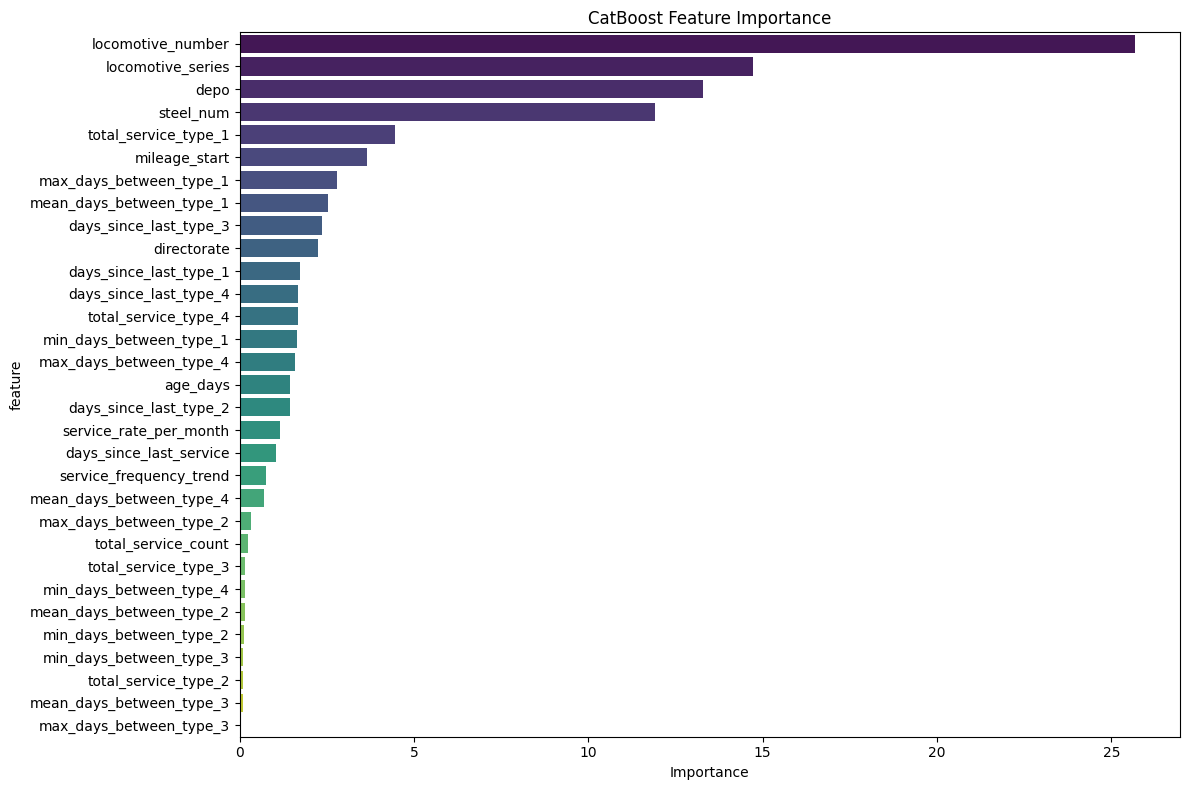

In [ ]:
# y_pred = model.predict(X_test)
# from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# print(f"\n=== РЕЗУЛЬТАТЫ МОДЕЛИ ===")
# print(f"MAE: {mean_absolute_error(y_test, y_pred):.4f}")
# print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.4f}")
# print(f"MAPE: {np.mean(np.abs((y_test - y_pred) / y_test)) * 100:.2f}%")
# print(f"R²: {r2_score(y_test, y_pred):.4f}")

# feature_importance = pd.DataFrame({
#     'feature': X_train.columns,
#     'importance': model.get_feature_importance()
# }).sort_values('importance', ascending=False)


# plt.figure(figsize=(12, 8))
# top_features = feature_importance
# sns.barplot(data=top_features, x='importance', y='feature', palette='viridis')
# plt.title('CatBoost Feature Importance')
# plt.xlabel('Importance')
# plt.tight_layout()
# plt.show()
